In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Oct 18 14:58:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

In [ ]:
import pickle
import os
import numpy as np
import pandas as pd
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

#Данные

##Импорт датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q /content/drive/MyDrive/Diplom/dog-breed-identification.zip -d dogs

##Даталоадер

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
l = pd.read_csv('/content/dogs/labels.csv', sep = ',')
p = pd.DataFrame()
p['id'] = l.iloc[:, 0] + '.jpg'
p['breed'] = l.iloc[:, 1]

d = {}
for i in range(0, p.shape[0]):
  d[p.iloc[i, 0]] = p.iloc[i, 1]

In [ ]:
class DogsDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    # список файлов для загрузки
    self.files = sorted(files)
    # режим работы
    self.mode = mode
    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError
    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()
    if self.mode != 'test':
      self.labels = [d[path.name] for path in self.files]
      #self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)
      with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
      return self.len_

  def load_sample(self, file):
      image = Image.open(file)
      image.load()
      return image
  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

  def __getitem__(self, index):
    transform_train = transforms.Compose([
          transforms.ToTensor(),
          transforms.ToPILImage(),
          transforms.RandomChoice([
                                   transforms.ColorJitter(),
          transforms.RandomGrayscale(p=0.1),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomRotation(20),
          ]),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 
    transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    if self.mode == 'test':
        return transform_test(x) #тестовую не меняем
    else:
        if self.mode == 'train':
          x= transform_train(x)
        else:
          x=transform_test(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
 inp = inp.numpy().transpose((1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 inp = std * inp + mean
 inp = np.clip(inp, 0, 1)
 plt_ax.imshow(inp)
 if title is not None:
   plt_ax.set_title(title)
 plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/dogs/train')
TEST_DIR = Path('/content/dogs/test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [d[path.name] for path in train_val_files]


test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

In [ ]:
train_dataset = DogsDataset(train_files, mode='train')

val_dataset = DogsDataset(val_files, mode='val')

test_dataset = DogsDataset(test_files, mode='test')

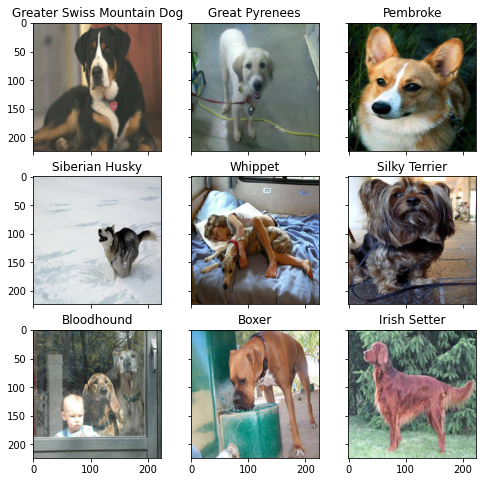

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,1000))
 im_val, label = val_dataset[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

##Статистика по датасету

####Тренировочная выборка

Общий объем выборки

In [ ]:
len(train_files)

7666

In [ ]:
breeds = {}

for i in train_files:
  breed = d[i.name]
  if breed in breeds.keys():
    breeds[breed] += 1
  else:
    breeds[breed] = 1
  

Количество классов

In [ ]:
len(breeds)

120

В среднем изображений в каждом классе

In [ ]:
sum(breeds.values()) / 120

63.88333333333333

В каком классе меньше всего

In [ ]:
min_val = 7666
breed_min = ""

for breed in breeds:
  if breeds[breed] < min_val:
    min_val = breeds[breed]
    breed_min = breed

print(breed_min, min_val)

eskimo_dog 50


В каком классе больше всего

In [ ]:
max_val = 0
breed_max = ""

for breed in breeds:
  if breeds[breed] > max_val:
    max_val = breeds[breed]
    breed_max = breed

print(breed_max, max_val)

scottish_deerhound 94


Распределение

<BarContainer object of 120 artists>

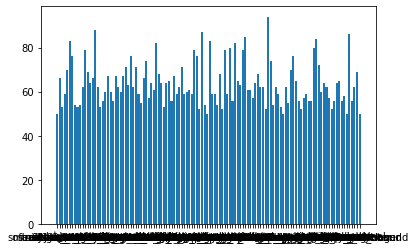

In [ ]:
plt.bar(*zip(*breeds.items()))

####Валидационная выборка

Всего изображений в валидационной выборке

In [ ]:
len(val_files)

2556

In [ ]:
breeds_val = {}

for i in val_files:
  breed_v = d[i.name]
  if breed_v in breeds_val.keys():
    breeds_val[breed_v] += 1
  else:
    breeds_val[breed_v] = 1

Всего классов в валидационной выборке

In [ ]:
len(breeds_val)

120

В среднем изображений в валидационной выборке

In [ ]:
sum(breeds_val.values()) / 120

21.3

Класс с наименьшим количеством изображений в валидационной выборке

In [ ]:
min_val = 3000
breed_min = ""

for breed in breeds_val:
  if breeds_val[breed] < min_val:
    min_val = breeds_val[breed]
    breed_min = breed

print(breed_min, min_val)

eskimo_dog 16


In [ ]:
max_val = 0
breed_max = ""

for breed in breeds_val:
  if breeds_val[breed] > max_val:
    max_val = breeds_val[breed]
    breed_max = breed

print(breed_max, max_val)

scottish_deerhound 32


<BarContainer object of 120 artists>

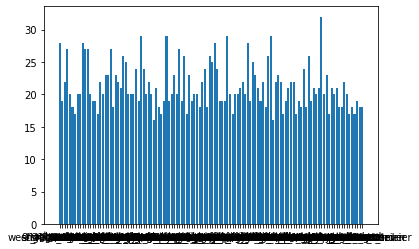

In [ ]:
plt.bar(*zip(*breeds_val.items()))

##Создание сокращенной выборки с сохранением распределения

In [ ]:
def create_short_dataset(new_dir, files, breed_dict):
  breeds_count_in_dir = {}

  if not os.path.isdir(new_dir):
      os.makedirs(new_dir)

  for path in files:
    breed = d[path.name]
    if breed in breeds_count_in_dir.keys():
      if breeds_count_in_dir[breed] < breed_dict[breed] * 0.5:
        img = Image.open(path)
        img.save(new_dir + path.name)
        breeds_count_in_dir[breed] += 1
    else:
      img = Image.open(path)
      img.save(new_dir + path.name)
      breeds_count_in_dir[breed] = 1

  max_val = 0
  min_val = 1000

  breed_max = ""
  breed_min = ""

  for breed in breeds_count_in_dir:
    if breeds_count_in_dir[breed] > max_val:
      max_val = breeds_count_in_dir[breed]
      breed_max = breed

    if breeds_count_in_dir[breed] < min_val:
      min_val = breeds_count_in_dir[breed]
      breed_min = breed

  print("Больше всего в классе %s: %d изображений" % (breed_max, max_val))
  print("Меньше всего в классе %s: %d изображений" % (breed_min, min_val))

  plt.bar(*zip(*breeds_count_in_dir.items()))

Больше всего в классе scottish_deerhound: 47 изображений
Меньше всего в классе eskimo_dog: 25 изображений


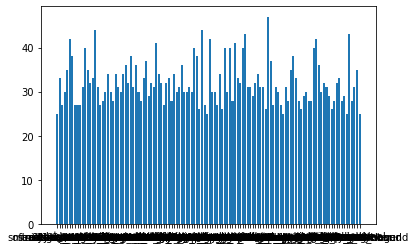

In [ ]:
! rm -rf /content/dogs_train_short/

new_dir = "/content/dogs_train_short/train/"
create_short_dataset(new_dir, train_files, breeds)

Больше всего в классе scottish_deerhound: 16 изображений
Меньше всего в классе eskimo_dog: 8 изображений


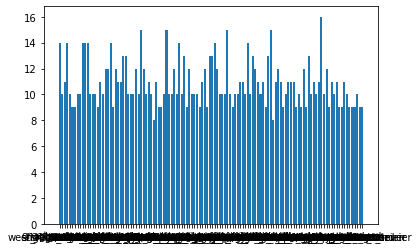

In [ ]:
! rm -rf /content/dogs_train_short/val/

new_dir = "/content/dogs_train_short/val/"
create_short_dataset(new_dir, val_files, breeds_val)

In [ ]:
import shutil
dir_name = "/content/dogs_train_short/train"
output_filename = "/content/drive/MyDrive/Diplom/dogs_short_train"
shutil.make_archive(output_filename, 'zip', dir_name)

'/content/drive/MyDrive/Diplom/dogs_short_train.zip'

In [ ]:
import shutil
dir_name = "/content/dogs_train_short/val"
output_filename = "/content/drive/MyDrive/Diplom/dogs_short_val"
shutil.make_archive(output_filename, 'zip', dir_name)

'/content/drive/MyDrive/Diplom/dogs_short_val.zip'